## Description

Predicting whether it will rain on a given day in Australia using XGBoost on Rain in Australia dataset on Kaggle.
- Dataset: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!ls

README.md      rainAUS.ipynb  weatherAUS.csv


In [3]:
df = pd.read_csv('weatherAUS.csv')

In [4]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
#change date col to datetime data type
df.Date = pd.to_datetime(df.Date)

## Exploratory Analysis

In [7]:
df_tmp = df.copy()

In [8]:
# set Date col as the index 
df_tmp.index = df_tmp.Date

In [9]:
#drop Date col
df_tmp.drop(['Date'], axis=1, inplace=True)

In [10]:
#check
df_tmp.head(2)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


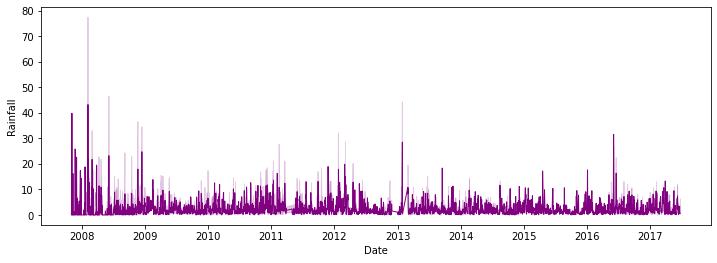

In [11]:
# Rainfull time series
fig = plt.figure(figsize=(12,4)) 
sns.lineplot(data=df_tmp['Rainfall'], color='purple', linewidth=1);

In [12]:
df_tmp=df_tmp.resample('M')[['Rainfall']].mean() # aggregate by month


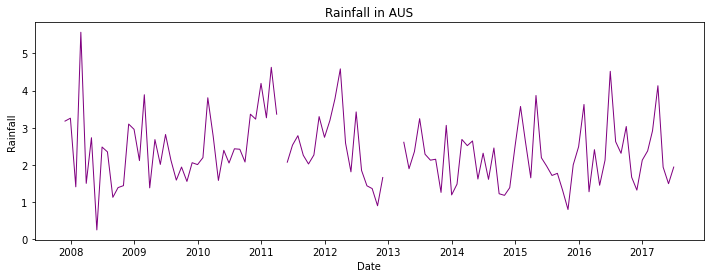

In [13]:
# Rainfull time series over months
plt.figure(figsize=(12,4)) 
plt.title("Rainfall in AUS")
sns.lineplot(data=df_tmp['Rainfall'], color='purple', linewidth=1);

Now that we did some exploratory analysis on the amount of rainfall over the years I want to go back to df to prep it for XGBoost

## Cleaning

### Define

drop unnecessary features/cols

### Code

In [14]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

I want to predict `RainToday` i.e our target

In [15]:
cols = ['Date', 'Location', 'Rainfall', 'RainTomorrow']
df.drop(cols, axis=1, inplace=True)

### Test

In [16]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainToday'],
      dtype='object')

### Define

Remove cols with more than **40%** Nans in them 

### Code

In [17]:
cols = df.isna().mean(axis=0)
cols

MinTemp          0.010209
MaxTemp          0.008669
Evaporation      0.431665
Sunshine         0.480098
WindGustDir      0.070989
WindGustSpeed    0.070555
WindDir9am       0.072639
WindDir3pm       0.029066
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
dtype: float64

In [18]:
cols_drop = cols[cols >= 0.4]
cols_drop

Evaporation    0.431665
Sunshine       0.480098
Cloud3pm       0.408071
dtype: float64

In [19]:
df.drop(cols_drop.index, axis=1, inplace=True)

### Test

In [20]:
df.columns

Index(['MinTemp', 'MaxTemp', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Temp9am',
       'Temp3pm', 'RainToday'],
      dtype='object')

In [21]:
df.head()

,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Temp9am,Temp3pm,RainToday
0,13.4,22.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,16.9,21.8,No
1,7.4,25.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,17.2,24.3,No
2,12.9,25.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,21.0,23.2,No
3,9.2,28.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,18.1,26.5,No
4,17.5,32.3,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,17.8,29.7,No


In [22]:
df.WindGustDir.nunique(), df.WindDir9am.nunique(), df.WindDir3pm.nunique()

(16, 16, 16)

In [23]:
3*16

48

In [24]:
15+48

63

### Define

### Code

### Test

## Split The Data

In [25]:
X = df.drop("RainToday", axis=1)
y = df.RainToday

## Preprocessing

For the categorical features, we will impute the missing values with the mode of the column and encode them with One-Hot encoding:

In [26]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [27]:
categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

For the numeric features, I will choose the mean as an imputer and StandardScaler so that the features have 0 mean and a variance of 1:

In [28]:
from sklearn.preprocessing import StandardScaler


In [29]:
numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)

Finally, we will combine the two pipelines with a column transformer. To specify which columns the pipelines are designed for, we should first isolate the categorical and numeric feature names:

In [30]:
cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

Next, we will input these along with their corresponding pipelines into a ColumnTransFormer instance:

In [31]:
from sklearn.compose import ColumnTransformer


In [32]:
full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

In [34]:
# Apply preprocessing
X_processed = full_processor.fit_transform(X)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
    y.values.reshape(-1, 1)
)

## Splitting the data

In [39]:
from sklearn.model_selection import train_test_split


In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, stratify=y_processed, random_state=1121220
)

## Applying XGBoost

In [50]:
import xgboost as xgb

In [51]:
xgb_cl = xgb.XGBClassifier()


In [52]:
xgb_cl.fit(X_train, y_train)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
preds = xgb_cl.predict(X_test)


In [55]:
from sklearn.metrics import accuracy_score

In [56]:
accuracy_score(y_test, preds)

0.8505431046335762

In [58]:
score = xgb_cl.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.8747971951051835
